In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os 
import ydata_profiling as yp
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/full_gen_data.csv')
df.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,customer_id,...,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255,0
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255,0
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255,0
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238,0
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,...,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238,0


In [3]:
df.drop([ 'article', 'customer_id', 'article.1', 'style', 'sizes', 'cost', 'sales', 'regular_price', 'current_price',
         'rgb_r_main_col', 'rgb_g_main_col', 'rgb_b_main_col', 'rgb_r_sec_col', 'rgb_g_sec_col', 'rgb_b_sec_col'], axis=1, inplace=True)

In [4]:
df.head()

,country,ratio,retailweek,promo1,promo2,productgroup,category,gender,label
0,Germany,0.663866,2016-03-27,0,0,SHOES,TRAINING,women,0
1,Germany,0.663866,2016-03-27,0,0,SHORTS,TRAINING,women,0
2,Germany,0.663866,2016-03-27,0,0,HARDWARE ACCESSORIES,GOLF,women,0
3,Germany,0.663866,2016-03-27,0,0,SHOES,RUNNING,kids,0
4,Germany,0.663866,2016-03-27,0,0,SHOES,RELAX CASUAL,women,0


In [5]:
df['retailweek'] = pd.to_datetime(df['retailweek'])
df['month'] = df['retailweek'].dt.month

df.drop(['retailweek'], axis=1, inplace=True)

In [6]:
df = df[['country', 'productgroup', 'category', 'gender', 'month',  'ratio', 'promo1', 'promo2', 'label']]
for col in df.columns:
    if col not in ['ratio', 'label']:
        df[col] = df[col].astype('category')

In [7]:
df.head()

,country,productgroup,category,gender,month,ratio,promo1,promo2,label
0,Germany,SHOES,TRAINING,women,3,0.663866,0,0,0
1,Germany,SHORTS,TRAINING,women,3,0.663866,0,0,0
2,Germany,HARDWARE ACCESSORIES,GOLF,women,3,0.663866,0,0,0
3,Germany,SHOES,RUNNING,kids,3,0.663866,0,0,0
4,Germany,SHOES,RELAX CASUAL,women,3,0.663866,0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   country       100000 non-null  category
 1   productgroup  100000 non-null  category
 2   category      100000 non-null  category
 3   gender        100000 non-null  category
 4   month         100000 non-null  category
 5   ratio         100000 non-null  float64 
 6   promo1        100000 non-null  category
 7   promo2        100000 non-null  category
 8   label         100000 non-null  int64   
dtypes: category(7), float64(1), int64(1)
memory usage: 2.2 MB


In [9]:
df.duplicated().sum()

22305

In [10]:
df.drop_duplicates(inplace=True)

<Axes: xlabel='label', ylabel='ratio'>

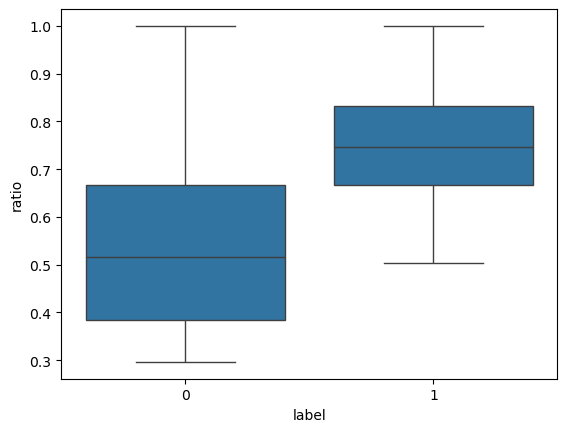

In [11]:
sns.boxplot(data=df, x='label', y='ratio')

In [12]:
profile = yp.ProfileReport(df)
repeat = 1
if not os.path.exists('../reports/fifth_eda_report.html') or repeat:
    prof = yp.ProfileReport(df)
    prof.to_file('../reports/fifth_eda_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
pd.pivot_table(df, index=['category'], columns=['country'], values=['label'], aggfunc='mean')

label                    
country            Austria    France   Germany
category                                      
FOOTBALL GENERIC  0.162162  0.151024  0.169781
GOLF              0.168902  0.143634  0.169938
INDOOR            0.168116  0.150231  0.154907
RELAX CASUAL      0.180797  0.155212  0.166353
RUNNING           0.166968  0.135333  0.168062
TRAINING          0.160928  0.150347  0.163857

In [14]:
pd.pivot_table(df, index=['category'], columns=['productgroup'], values=['label'], aggfunc='mean')

label                                
productgroup     HARDWARE ACCESSORIES     SHOES    SHORTS SWEATSHIRTS
category                                                             
FOOTBALL GENERIC                  NaN  0.163953       NaN         NaN
GOLF                         0.165207       NaN       NaN         NaN
INDOOR                            NaN  0.158824       NaN         NaN
RELAX CASUAL                      NaN  0.169627       NaN         NaN
RUNNING                      0.163452  0.160937       NaN         NaN
TRAINING                          NaN  0.161070  0.159006     0.16161

In [15]:
df.describe(include='category')

,country,productgroup,category,gender,month,promo1,promo2
count,77695,77695,77695,77695,77695,77695,77695
unique,3,4,6,4,12,2,2
top,Germany,SHOES,TRAINING,women,1,0,0
freq,37130,46608,23318,54387,9886,71737,77231


In [16]:
df.describe().round(2)

,ratio,label
count,77695.00,77695.00
mean,0.57,0.16
std,0.18,0.37
min,0.30,0.00
25%,0.41,0.00
50%,0.57,0.00
75%,0.71,0.00
max,1.00,1.00


In [17]:
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((62156, 8), (15539, 8), (62156,), (15539,))

In [18]:
cat_cols = ['country', 'productgroup', 'category', 'gender', 'month', 'promo1', 'promo2']
num_cols = ['ratio']

preprocessor = ColumnTransformer([ ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols),
                                 ], remainder='passthrough')
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_train_prep.shape, X_test_prep.shape

((62156, 27), (15539, 27))

In [19]:
log_reg = LogisticRegression(random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')

lr_cv_results = cross_validate(log_reg, X_train_prep, y_train, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(lr_cv_results['test_accuracy'].mean())
print(lr_cv_results['test_precision'].mean())
print(lr_cv_results['test_recall'].mean())
print(lr_cv_results['test_f1'].mean())
print(lr_cv_results['test_roc_auc'].mean())

0.7270739294289291
0.3527519111849126
0.8105159734202912
0.49155644615613925
0.8309088776720228


In [20]:
log_reg_param_grid = {
    'C': [0.01, 0.1, 10],
    'penalty': ['l1', 'l2']
}

log_reg_grid_search = GridSearchCV(log_reg, log_reg_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
log_reg_grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=42,
                                          solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 10], 'penalty': ['l1', 'l2']},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [21]:
log_reg_grid_search_results = pd.DataFrame(log_reg_grid_search.cv_results_)
log_reg_grid_search_results = log_reg_grid_search_results[['param_C', 'param_penalty', 'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
log_reg_grid_search_results.round(2)

,param_C,param_penalty,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,0.01,l1,0.73,0.35,0.81,0.49
1,0.01,l2,0.71,0.34,0.84,0.48
2,0.1,l1,0.73,0.35,0.81,0.49
3,0.1,l2,0.72,0.35,0.82,0.49
4,10,l1,0.73,0.35,0.81,0.49
5,10,l2,0.73,0.35,0.81,0.49


	 Log Reg classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     52039
           1       0.34      0.84      0.49     10117

    accuracy                           0.71     62156
   macro avg       0.65      0.76      0.64     62156
weighted avg       0.86      0.71      0.75     62156

############################################################
	 Log Reg confusion matrix on training set
############################################################


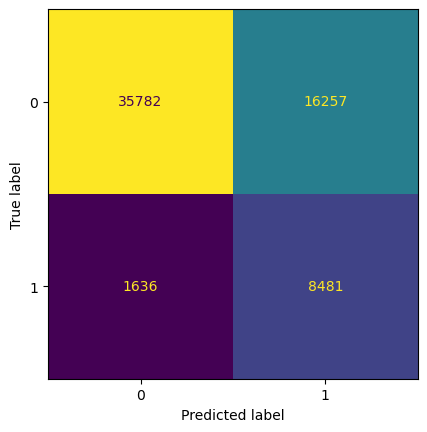

In [22]:
best_log_reg_params = {
    'C': 0.01,
    'penalty': 'l2'}

best_log_reg = LogisticRegression(**best_log_reg_params, random_state=42, max_iter=10000, solver='liblinear', class_weight='balanced')
best_log_reg.fit(X_train_prep, y_train)

y_train_pred_lr = best_log_reg.predict(X_train_prep)

print("\t Log Reg classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_lr))
print('#'*60)

print("\t Log Reg confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_lr, colorbar=False)

In [23]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_cv_results = cross_validate(rf, X_train_prep, y_train, cv=5, scoring=['accuracy', 'precision', 'recall' , 'f1', 'roc_auc'])
print(rf_cv_results['test_accuracy'].mean())
print(rf_cv_results['test_precision'].mean())
print(rf_cv_results['test_recall'].mean())
print(rf_cv_results['test_f1'].mean())
print(rf_cv_results['test_roc_auc'].mean())

0.7691776262627361
0.2921993945043124
0.2938596945404528
0.29297746331441954
0.7535508292366222


In [24]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [None, 'sqrt'],
    'max_depth': [10, 20, 30],
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=3, refit=False, scoring=['accuracy', 'precision', 'recall' , 'f1'])
rf_grid_search.fit(X_train_prep, y_train)


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': [None, 'sqrt'],
                         'n_estimators': [100, 200, 300]},
             refit=False, scoring=['accuracy', 'precision', 'recall', 'f1'])

In [25]:
rf_grid_search_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_grid_search_results = rf_grid_search_results[['param_n_estimators', 'param_max_depth', 'param_max_features',  'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']]
rf_grid_search_results.round(2)

,param_n_estimators,param_max_depth,param_max_features,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,100,10,None,0.70,0.33,0.88,0.48
1,200,10,None,0.69,0.33,0.88,0.48
2,300,10,None,0.69,0.33,0.88,0.48
3,100,10,sqrt,0.67,0.32,0.92,0.47
4,200,10,sqrt,0.67,0.32,0.92,0.47
5,300,10,sqrt,0.67,0.32,0.92,0.47
6,100,20,None,0.77,0.35,0.50,0.41
7,200,20,None,0.77,0.35,0.49,0.41
8,300,20,None,0.77,0.35,0.49,0.41
9,100,20,sqrt,0.75,0.33,0.52,0.41


	 RF classification report on training set
############################################################
              precision    recall  f1-score   support

           0       0.98      0.62      0.76     52039
           1       0.33      0.95      0.49     10117

    accuracy                           0.67     62156
   macro avg       0.66      0.79      0.62     62156
weighted avg       0.88      0.67      0.72     62156

############################################################
	 RF confusion matrix on training set
############################################################


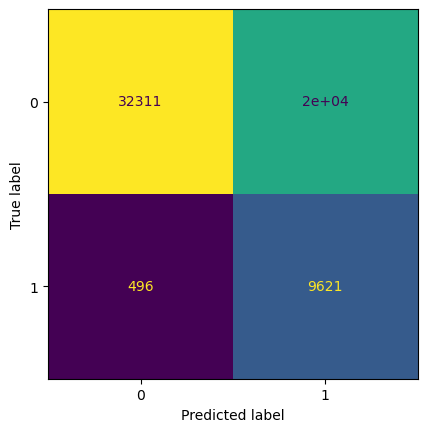

In [26]:
rf_grid_search_best_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'max_features': 'sqrt'
}

best_rf = RandomForestClassifier(**rf_grid_search_best_params, random_state=42, class_weight='balanced')
best_rf.fit(X_train_prep, y_train)

y_train_pred_rf = best_rf.predict(X_train_prep)

print("\t RF classification report on training set")
print('#'*60)
print(classification_report(y_train, y_train_pred_rf))
print('#'*60)

print("\t RF confusion matrix on training set")
print('#'*60)

_ = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred_rf, colorbar=False)

In [27]:
y_train_proba_lr = best_log_reg.predict_proba(X_train_prep)[:, 1]
y_train_proba_rf = best_rf.predict_proba(X_train_prep)[:, 1]

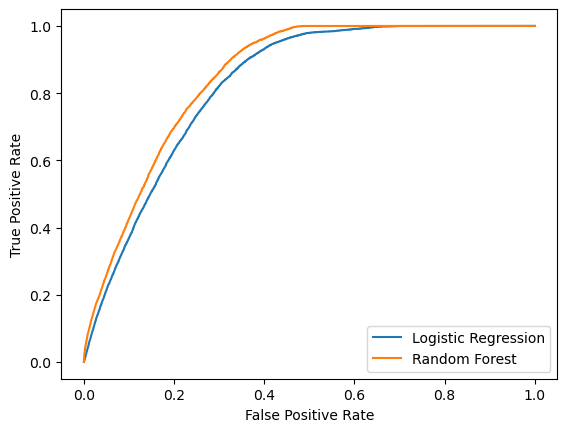

In [28]:
lr_fpr, lr_tpr, _ = roc_curve(y_train, y_train_proba_lr)
rf_fpr, rf_tpr, _ = roc_curve(y_train, y_train_proba_rf)

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression')
plt.plot(rf_fpr, rf_tpr, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

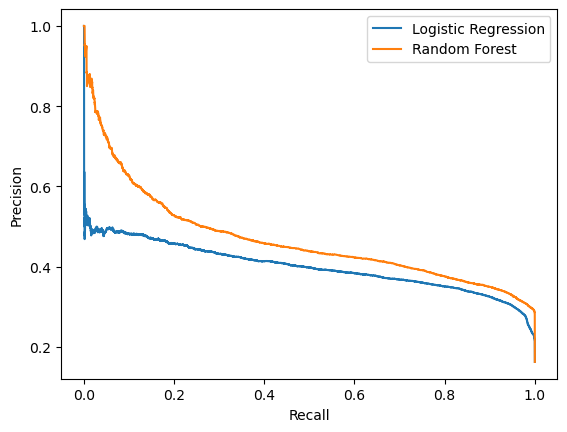

In [29]:
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_train, y_train_proba_lr)
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(y_train, y_train_proba_rf)

plt.plot(lr_recall, lr_precision, label='Logistic Regression')
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

	 RF classification report on training set
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     52039
           1       0.38      0.77      0.51     10117

    accuracy                           0.76     62156
   macro avg       0.66      0.77      0.68     62156
weighted avg       0.85      0.76      0.79     62156



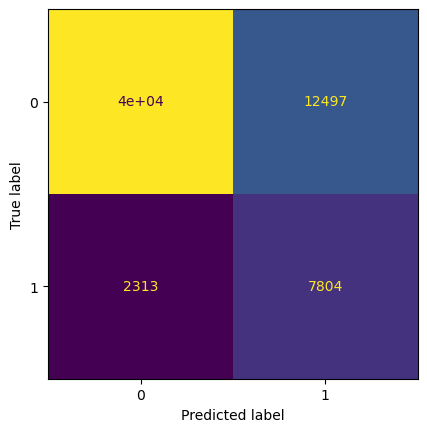

In [30]:
# For Rf: we will increase Probability threshold
prob_threshold = 0.65
rf_train_pred = best_rf.predict_proba(X_train_prep)[:, 1] > prob_threshold

print("\t RF classification report on training set")
print(classification_report(y_train, rf_train_pred))

ConfusionMatrixDisplay.from_predictions(y_train, rf_train_pred, colorbar=False)

In [31]:
from sklearn.pipeline import Pipeline

best_model = Pipeline([
    ('prep', preprocessor),
    ('rf', best_rf)
])


best_model.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['country', 'productgroup',
                                                   'category', 'gender',
                                                   'month', 'promo1',
                                                   'promo2'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        random_state=42))])

	 RF classification report on test set
############################################################
              precision    recall  f1-score   support

           0       0.93      0.75      0.83     13010
           1       0.36      0.71      0.48      2529

    accuracy                           0.75     15539
   macro avg       0.65      0.73      0.66     15539
weighted avg       0.84      0.75      0.78     15539

############################################################
	 RF confusion matrix on test set
############################################################


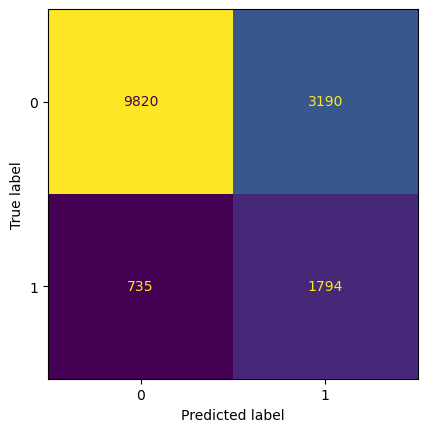

In [32]:
# Predict on test data
prob_threshold = 0.65
y_test_pred = best_model.predict_proba(X_test)[:, 1] > prob_threshold

print("\t RF classification report on test set")
print('#'*60)
print(classification_report(y_test, y_test_pred))
print('#'*60)

print("\t RF confusion matrix on test set")
print('#'*60)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, colorbar=False)

In [33]:
if not os.path.exists('../models'):
    os.makedirs('../models')

joblib.dump((best_model, prob_threshold), '../models/rf_model_less_features_with_threshold.joblib')

['../models/rf_model_less_features_with_threshold.joblib']

In [34]:
df.to_csv('../data/data_less_features.csv', index=False)

In [38]:
# Plot and save the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, colorbar=False)
plt.title("RF (less features) Confusion Matrix")
plt.savefig("../reports/rf_less_features_confusion_matrix.png", bbox_inches="tight")
plt.close()